# Second order updates on the $\alpha_{\epsilon}(A)$ level set
This script serves to measure the effectiveness of different retractions on the smoothed spectral abscissa level set

In [1]:
import numpy as np
from scipy.linalg import solve_continuous_lyapunov
import matplotlib.pyplot as plt
from tqdm import tqdm
from ssa import ssa, optimize_ssa, ssa_newton_retraction

In [2]:
def lyap_differential(X: np.array, Y: np.array, V: np.array):
    Q = V @ Y + Y @ V.T
    return solve_continuous_lyapunov(X, -Q)

def random_tangent(g: np.array):

    # flatten and remember original shape
    orig_shape = g.shape    
    g = np.ravel(g)

    # generate random ambient vector
    v = np.random.random(size=(g.size,))

    # remove the component in the direction of g
    g_comp = np.dot(v, g) / np.dot(g, g)
    v = v - (g_comp * g)

    # rescale
    v = v / np.linalg.norm(v)

    # reshape
    v = np.reshape(v, orig_shape)

    return v

def hvp(A: np.array, V: np.array, s: float, Q: np.array, P: np.array):

    n = A.shape[0]

    DVP = lyap_differential(A - s * np.identity(n), P, V)
    DVQ = lyap_differential(A.T - s * np.identity(n), Q, V)

    DVQP = DVQ @ P + Q @ DVP

    QP = Q@P
    TrQP = np.trace(QP)
    TrDVQP = np.trace(DVQP)

    DV_ssa = ((DVQP * TrQP) - (QP * TrDVQP)) / (TrQP**2)

    return DV_ssa

def compute_corrections(A: np.array, V: np.array, s: float, G: np.array, Q: np.array, P: np.array):

    # compute Hessian-Vector products
    H_1 = hvp(A, G, s, Q, P)
    H_2 = hvp(A, V, s, Q, P)

    h_1 = np.ravel(H_1)
    h_2 = np.ravel(H_2)
    g = np.ravel(G)
    v = np.ravel(V)

    # compute coefficients of the quadratic
    a = np.dot(g, h_1)
    b = 2 * (np.dot(g, g) + np.dot(g, h_1))
    c = np.dot(v, h_2)

    alpha_1 = -c / (np.dot(g, g)) # no need for h_1
    # NOTE: should maybe be using the stable version of the quadratic formula
    # alpha_2_1 = (-b + np.sqrt(b**2 - 4 * a * c)) / (2 * a) # quadratic solution +
    # alpha_2_2 = (-b - np.sqrt(b**2 - 4 * a * c)) / (2 * a) # quadratic solutoin -

    alpha_2_1 = (2 * c) / (-b - np.sqrt(b**2 - 4 * a * c))
    alpha_2_2 = (2 * c) / (-b + np.sqrt(b**2 - 4 * a * c))


    return alpha_1, alpha_2_1, alpha_2_2

In [3]:
N = 32
n_matrices = 100
eps = 0.01
target = -0.1

In [4]:
# generate a lot of stability optimized matrices
As = [optimize_ssa(np.random.normal(0.0, 1.0, size=(N, N)), eps, target, step_size=0.001, iters=70)[0] for i in tqdm(range(n_matrices))]

100%|██████████| 100/100 [00:21<00:00,  4.63it/s]


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 23.,
        73.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-6.37932524, -5.91453883, -5.44975241, -4.984966  , -4.52017958,
        -4.05539317, -3.59060676, -3.12582034, -2.66103393, -2.19624751,
        -1.7314611 , -1.26667468, -0.80188827, -0.33710186,  0.12768456,
         0.59247097,  1.05725739,  1.5220438 ,  1.98683021,  2.45161663,
         2.91640304,  3.38118946,  3.84597587,  4.31076229,  4.7755487 ,
         5.24033511,  5.70512153,  6.16990794,  6.63469436,  7.09948077,
         7.56426719,  8.0290536 ,  8.49384001,  8.95862643,  9.42341284,
         9.88819926, 10.35298567, 10.81777209, 11.2825585 , 11.74734491,
        12.21213133, 12.67691774, 13.14170416, 13.60649057, 14.07127699,
        14.5360634 , 15.00084981, 15.46563623, 15.93042264,

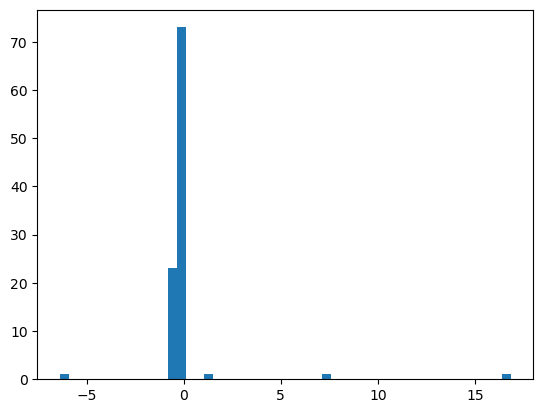

In [5]:
# check that their spectral abscissa are below 0
plt.hist(np.array([np.max(np.real(np.linalg.eigvals(A))) for A in As]), bins=50)

In [6]:
step_size = 1.0

In [7]:
s_dels = [] # step
sp_dels = [] # step, project
sfc_dels = [] # step, FO correct
sfcp_dels = [] # step, FO correct, project
ssc_1_dels = [] # step, SO correct
ssc_1p_dels = [] # step, SO correct, project
ssc_2_dels = [] # step, SO correct
ssc_2p_dels = [] # step, SO correct, project

fo_cs = []
so_c_1s = []
so_c_2s = []

# for each array
for A in As:    

    ## find the current ssa and gradient
    s, G, Q, P = ssa(A, eps, ret_QP=True)
    
    ## pick a direction tangent to the surface
    V = random_tangent(G) * step_size

    ## step
    A_s = A + V

    ## step, project
    A_sp = ssa_newton_retraction(A, V, eps, target)

    fo_c, so_c_1, so_c_2 = compute_corrections(A, V, s, G, Q, P)
    fo_cs.append(fo_c)
    so_c_1s.append(so_c_1)
    so_c_2s.append(so_c_2)

    ## step, FO correct
    A_sfc = A_s + (fo_c * G)
    ## step, FO correct, project
    A_sfcp = ssa_newton_retraction(A, V + (fo_c * G), eps, target)
    
    ## step, SO correct
    A_ssc_1 = A_s + (so_c_1 * G)
    A_ssc_2 = A_s + (so_c_2 * G)
    ## step, SO correct, project
    A_ssc_1p = ssa_newton_retraction(A, V + (so_c_1 * G), eps, target)
    A_ssc_2p = ssa_newton_retraction(A, V + (so_c_2 * G), eps, target)
    
    # find difference from the original s:
    s_dels.append(ssa(A_s, eps, grad=False, ret_QP=False) - s)
    sp_dels.append(ssa(A_sp, eps, grad=False, ret_QP=False) - s)
    sfc_dels.append(ssa(A_sfc, eps, grad=False, ret_QP=False) - s)
    sfcp_dels.append(ssa(A_sfcp, eps, grad=False, ret_QP=False) - s)
    ssc_1_dels.append(ssa(A_ssc_1, eps, grad=False, ret_QP=False) - s)
    ssc_1p_dels.append(ssa(A_ssc_1p, eps, grad=False, ret_QP=False) - s)
    ssc_2_dels.append(ssa(A_ssc_2, eps, grad=False, ret_QP=False) - s)
    ssc_2p_dels.append(ssa(A_ssc_2p, eps, grad=False, ret_QP=False) - s)


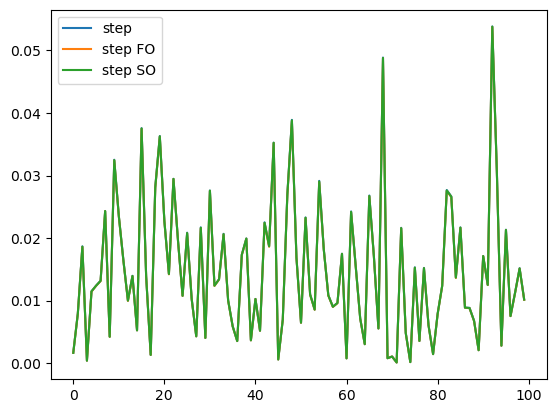

In [8]:
plt.plot(np.abs(s_dels), label="step")
# plt.plot(np.abs(sp_dels))
plt.plot(np.abs(sfc_dels), label="step FO")
# plt.plot(np.abs(sfcp_dels))
plt.plot(np.abs(ssc_1_dels), label="step SO")
# plt.plot(np.abs(ssc_1p_dels))
plt.legend()
plt.show()

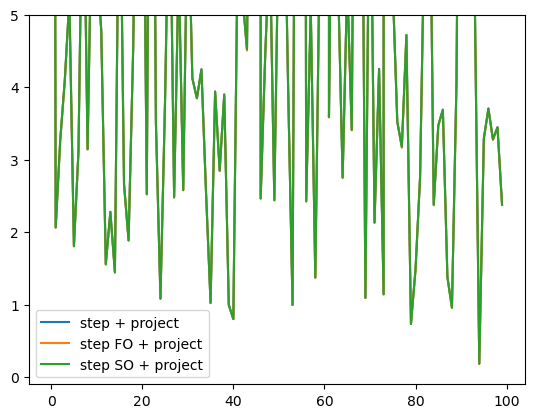

In [15]:
plt.plot(np.abs(sp_dels), label="step + project")
plt.plot(np.abs(sfcp_dels), label="step FO + project")
plt.plot(np.abs(ssc_1p_dels), label="step SO + project")
plt.legend()
plt.ylim(-0.1, 5.0)
plt.show()

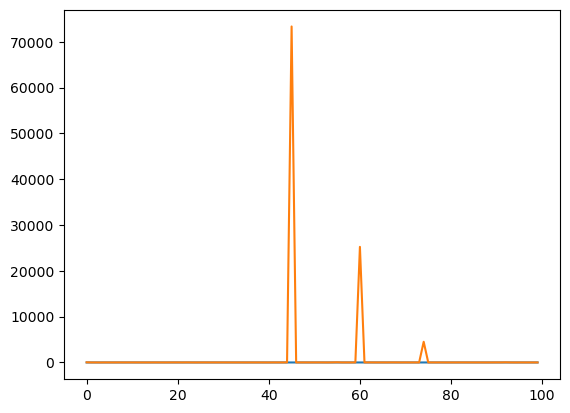

In [10]:
plt.plot(s_dels)
plt.plot(sp_dels)
plt.show()

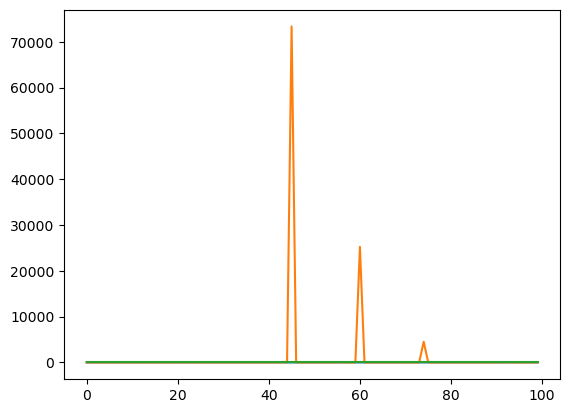

In [11]:
plt.plot(sfc_dels)
plt.plot(sfcp_dels)
plt.plot(fo_cs)
plt.show()

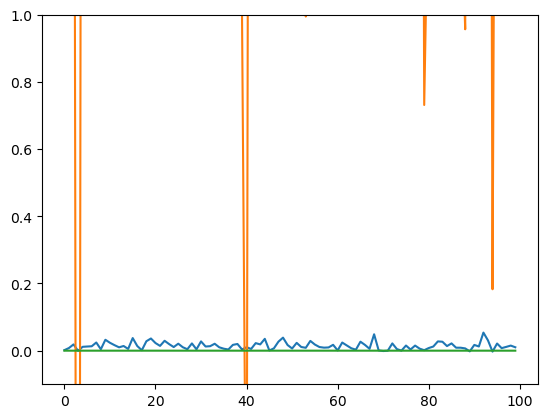

In [12]:
plt.plot(ssc_1_dels)
plt.plot(ssc_1p_dels)
plt.plot(so_c_1s)
plt.ylim(-0.1, 1.0)
plt.show()

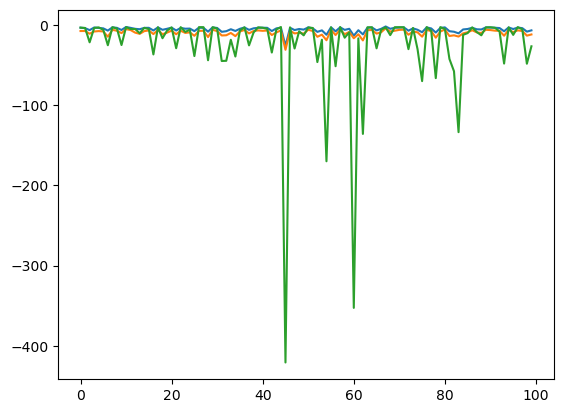

In [13]:
plt.plot(ssc_2_dels)
plt.plot(ssc_2p_dels)
plt.plot(so_c_2s)
plt.show()